In [1]:
from mp_api.client import MPRester
#from pymatgen.ext.matproj import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from jupyter_jsmol.pymatgen import quick_view
from pymatgen.core.operations import *
from pymatgen.analysis.diffraction.xrd import XRDCalculator
from pymatgen.electronic_structure.plotter import BSPlotter
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.image as img
from IPython.display import Image

In [2]:
mp_id = "mp-37906"
api_key = "U5rwd3sdglPsztvgTrc7TwUsvvfTEfOn"
api_key_legacy = "K2kftQLmglZDdrvU"

# Structure from material id
with MPRester(api_key) as m:
    band_structure = m.get_bandstructure_by_material_id(mp_id)

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
bsplot = BSPlotter(band_structure)

## Affichage de la structure des bandes
Sur le graphe ci-dessous, nous pouvons voir la structure de bandes électroniques correspondant au matériau LiMgN.
Cette structure possède au total 10 bandes de différentes énergies.

Pour des raisons de visibilité, le graphe est réduit à une zone autour de la bande interdite, ce graphe sera utilisé pour le reste du notebook.

<module 'matplotlib.pyplot' from 'C:\\Users\\Cyril\\OneDrive - UCL\\Projets_informatiques\\Python\\Tache\\lib\\site-packages\\matplotlib\\pyplot.py'>

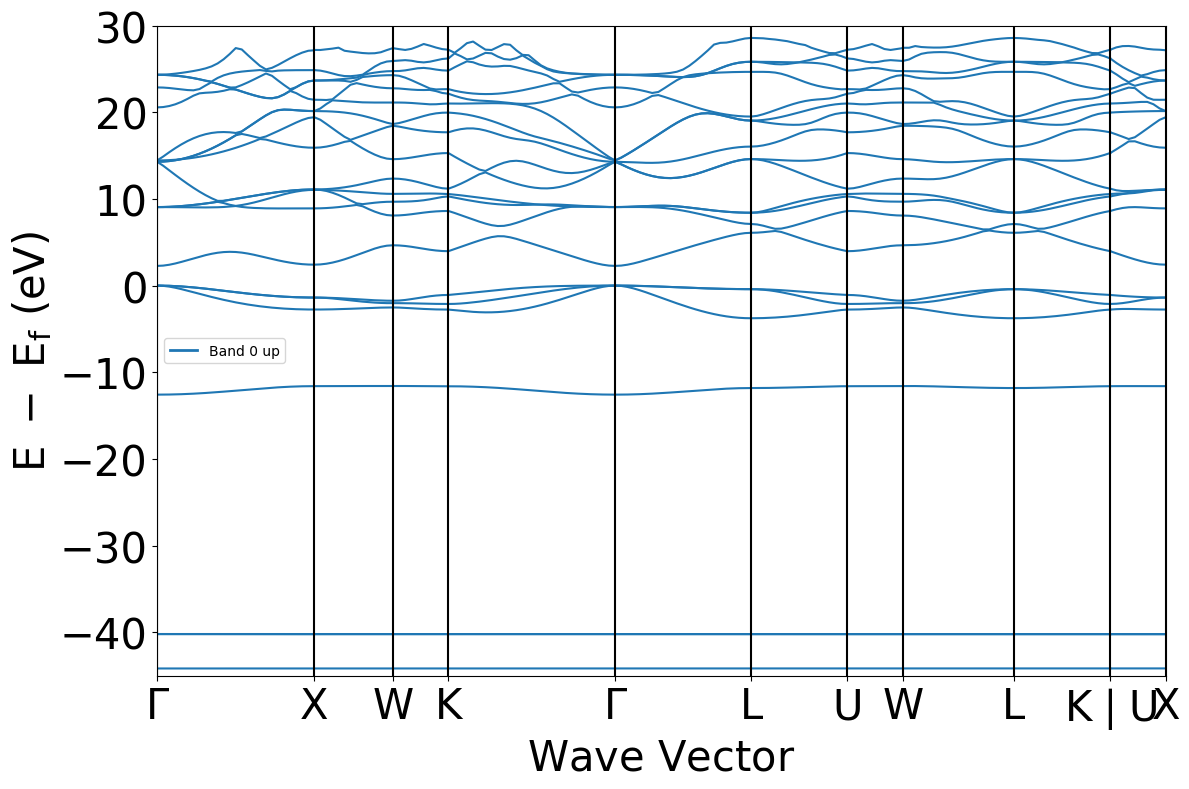

In [4]:
bsplot.get_plot(ylim=[-45, 30])

# Détermination de la bande interdite
La bande interdite nous permet de déterminer la nature du matériau semi-conducteur considéré.
Dans notre cas, cette bande interdite est directe et le gap d'énergie correspond à une énergie de 2,27 eV.

Sur le graphe ci-dessous, les points verts correspondent aux CBMs (Conduction Band Maximums) et donc aux vecteurs d'onde où l'énergie dans la bande de conduction est maximale.
De la même manière, les points rouges sont les VBMs (Valence Band Minimums) et ainsi aux vecteurs d'onde où l'énergie dans la bande de valence est minimale.

Bande directe: True
Gap d'énergie de la bande interdite: 2.2706999999999997 eV


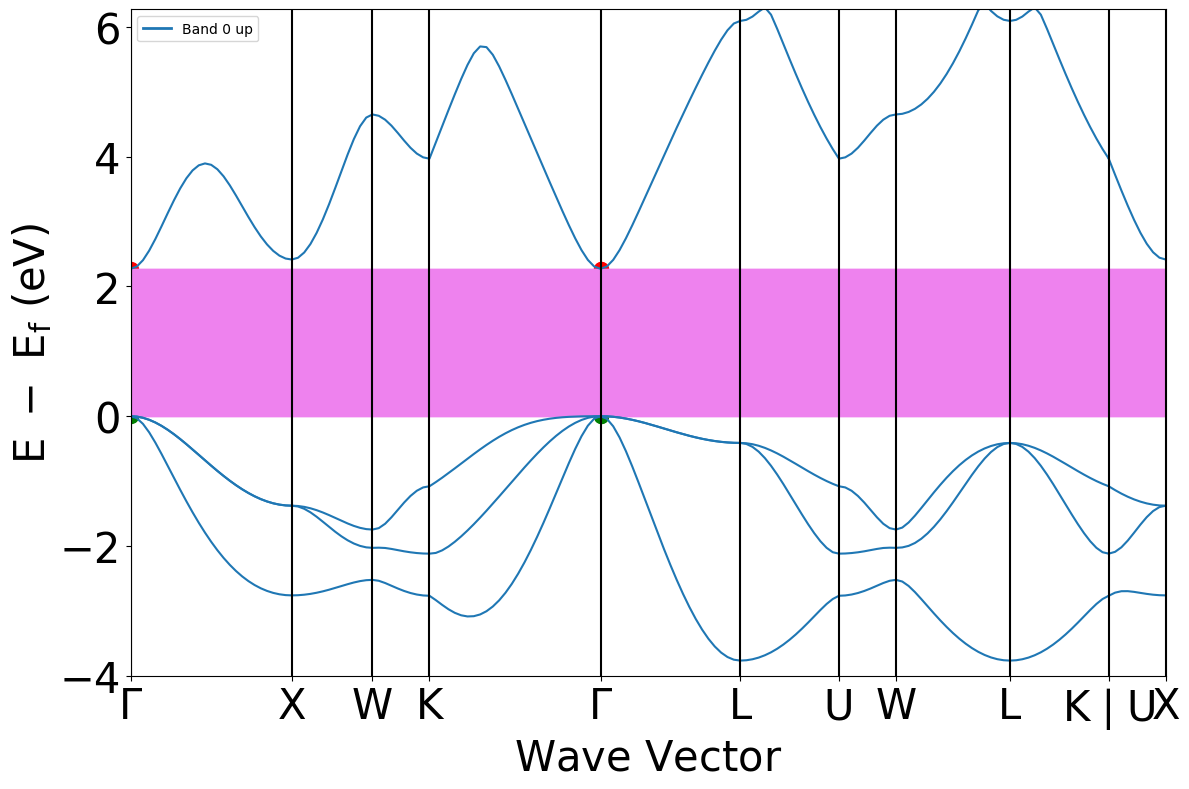

In [5]:
band_data = bsplot.bs_plot_data()
distance = band_data.get('ticks').get('distance')
distances = band_data.get('distances')

band_gap = band_structure.get_band_gap()
print(f"Bande directe: {band_gap['direct']}")
print(f"Gap d'énergie de la bande interdite: {band_gap['energy']} eV")

bsplot.get_plot(vbm_cbm_marker=True)
plt.fill_between(np.linspace(distance[0], distance[-1], 1000), 0, band_gap.get('energy'), color = "violet")

# Direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion
Pour déterminer la dernière bande de valence et la première bande de conduction, nous devons regarder aux VBMs et CBMs comme expliquer précédemment.

In [6]:
VBMs = list(band_structure.get_vbm()['band_index'].values())[0]
CBMs = list(band_structure.get_cbm()['band_index'].values())[0]
print(f"Numéro des bandes atteignant le VBM: {VBMs}")
print(f"Numéro de la bande atteignant le CBM: {CBMs}")

Numéro des bandes atteignant le VBM: [5, 6, 7]
Numéro de la bande atteignant le CBM: [8]


Pour ce matériau considéré, 3 bandes de valence atteignent le VBM, les numéros 5, 6 et 7.
À l'inverse seul une bande de conduction atteint le CBM, la bande numéro 8.

### Détermination de la dispersion minimale et maximale
Pour trouver les dispersions, on observe les pentes sur le graphe de la structure de bandes électroniques. On écrit cette dispersion sous la forme d'un rapport entre la variation d'énergie sur la variation de distance: $\frac{\Delta E}{\Delta k}$

Le code ci-dessous nous permet de trouver la plus grande et la plus petite dispersion respectivement sur la bande de conduction (bande n°8) et sur la bande de valence (n°5).
Comme expliqué précédemment, plusieurs bandes de valence atteignent le VBM, cependant, la bande n°5 possède les pentes les plus importantes et est donc la plus intéressante à analyser.

In [7]:
energy = band_data.get('energy')['1']

n = len(distances)
slopes_conduction = np.zeros(n)
slopes_valence = np.zeros(n)

for i in range(n):
    dist = distances[i][-1] - distances[i][0]
    d_energy_conduction = energy[i][8][-1] - energy[i][8][0]
    slopes_conduction[i] = np.abs(d_energy_conduction / dist)

    d_energy_valence = energy[i][5][-1] - energy[i][5][0]
    slopes_valence[i] = np.abs(d_energy_valence / dist)

# Plus grande/petite dispersion pour la bande de conduction
cond_max_idx = np.argmax(slopes_conduction)
cond_min_idx = np.argmin(slopes_conduction)

cond_max_X0 = distances[cond_max_idx][0]
cond_max_Y0 = energy[cond_max_idx][8][0]
cond_max_dX = distances[cond_max_idx][-1] - distances[cond_max_idx][0]
cond_max_dY = energy[cond_max_idx][8][-1] - energy[cond_max_idx][8][0]
cond_max_slope = abs((energy[cond_max_idx][8][-1] - energy[cond_max_idx][8][0])/(distances[cond_max_idx][-1] - distances[cond_max_idx][0]))

cond_min_X0 = distances[cond_min_idx][0]
cond_min_Y0 = energy[cond_min_idx][8][0]
cond_min_dX = distances[cond_min_idx][-1] - distances[cond_min_idx][0]
cond_min_dY = energy[cond_min_idx][8][-1] - energy[cond_min_idx][8][0]
cond_min_slope = abs((energy[cond_min_idx][8][-1] - energy[cond_min_idx][8][0])/(distances[cond_min_idx][-1] - distances[cond_min_idx][0]))

# Plus grande/petite dispersion pour la bande de valence
val_max_idx = np.argmax(slopes_valence)
val_min_idx = np.argmin(slopes_valence)

val_max_X0 = distances[val_max_idx][0]
val_max_Y0 = energy[val_max_idx][5][0]
val_max_dX = distances[val_max_idx][-1] - distances[val_max_idx][0]
val_max_dY = energy[val_max_idx][5][-1] - energy[val_max_idx][5][0]
val_max_slope = abs((energy[val_max_idx][5][-1] - energy[val_max_idx][5][0])/(distances[val_max_idx][-1] - distances[val_max_idx][0]))

val_min_X0 = distances[val_min_idx][0]
val_min_Y0 = energy[val_min_idx][5][0]
val_min_dX = distances[val_min_idx][-1] - distances[val_min_idx][0]
val_min_dY = energy[val_min_idx][5][-1] - energy[val_min_idx][5][0]
val_min_slope = abs((energy[val_min_idx][5][-1] - energy[val_min_idx][5][0])/(distances[val_min_idx][-1] - distances[val_min_idx][0]))

In [9]:
print("Pour la bande de conduction:")
print(r"La dispersion maximale est dans la direction X-W, avec une pente de:" + str(cond_max_slope))
print(r"La dispersion minimale est dans la direction Γ-X, avec une pente de:" + str(cond_min_slope))
print("\n")
print("Pour la bande de valence:")
print(r"La dispersion maximale est dans la direction Γ-L, avec une pente de: " + str(val_max_slope))
print(r"La dispersion minimale est dans la direction K|U-X, avec une pente de: " + str(val_min_slope))

Pour la bande de conduction:
La dispersion maximale est dans la direction X-W, avec une pente de:3.5667655055139167
La dispersion minimale est dans la direction Γ-X, avec une pente de:0.11422328034475207


Pour la bande de valence:
La dispersion maximale est dans la direction Γ-L, avec une pente de: 3.469393340016298
La dispersion minimale est dans la direction K|U-X, avec une pente de: 0.013310936620021032


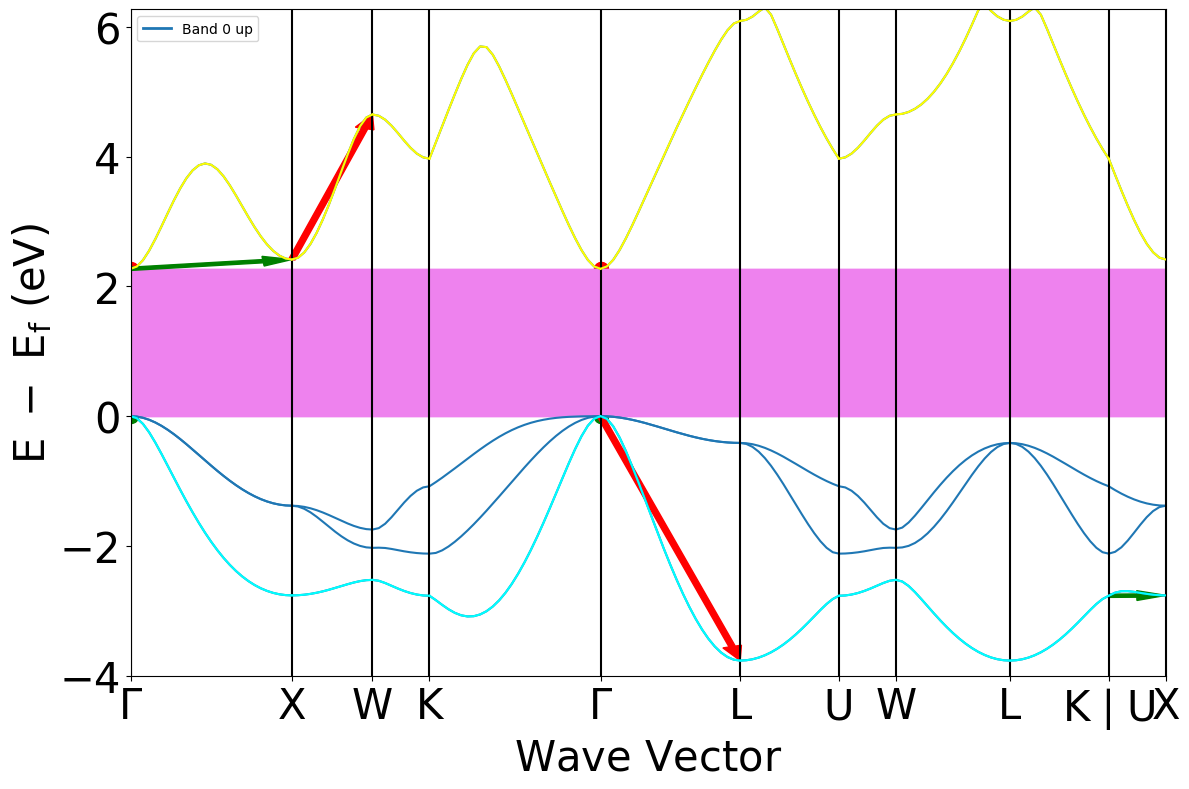

In [11]:
# On plot toutes ces fleches sur le graphe
bsplot.get_plot(vbm_cbm_marker=True)

for i in range(len(distances)):
    plt.plot(distances[i],energy[i][5],'cyan')
    plt.plot(distances[i],energy[i][8],'yellow')

plt.fill_between(np.linspace(distance[0], distance[-1], 1000), 0, band_gap.get('energy'), color = "violet")
plt.arrow(val_max_X0, val_max_Y0,val_max_dX, val_max_dY, color = 'r',width = 0.05,length_includes_head = True)
plt.arrow(cond_max_X0, cond_max_Y0,cond_max_dX, cond_max_dY, color = 'r',width = 0.05,length_includes_head = True)

plt.arrow(val_min_X0, val_min_Y0,val_min_dX, val_min_dY, color = 'g',width = 0.05,length_includes_head = True)
plt.arrow(cond_min_X0, cond_min_Y0,cond_min_dX, cond_min_dY, color = 'g',width = 0.05,length_includes_head = True)

### Masse effective
Le calcul de la masse effective est donné par la formule suivante:
$m^{*}_{i,j} = \hbar^{2} \left(\frac{\partial^{2}E}{\partial k_{i}\partial k_{j}}\right)^{-1}$

On suppose une dispersion parabolique, on crée donc une équation du second ordre sous la forme:
$E = a k^2 + b k + c$
On peut trouver les coefficients a, b, c en utilisant 3 points connus.

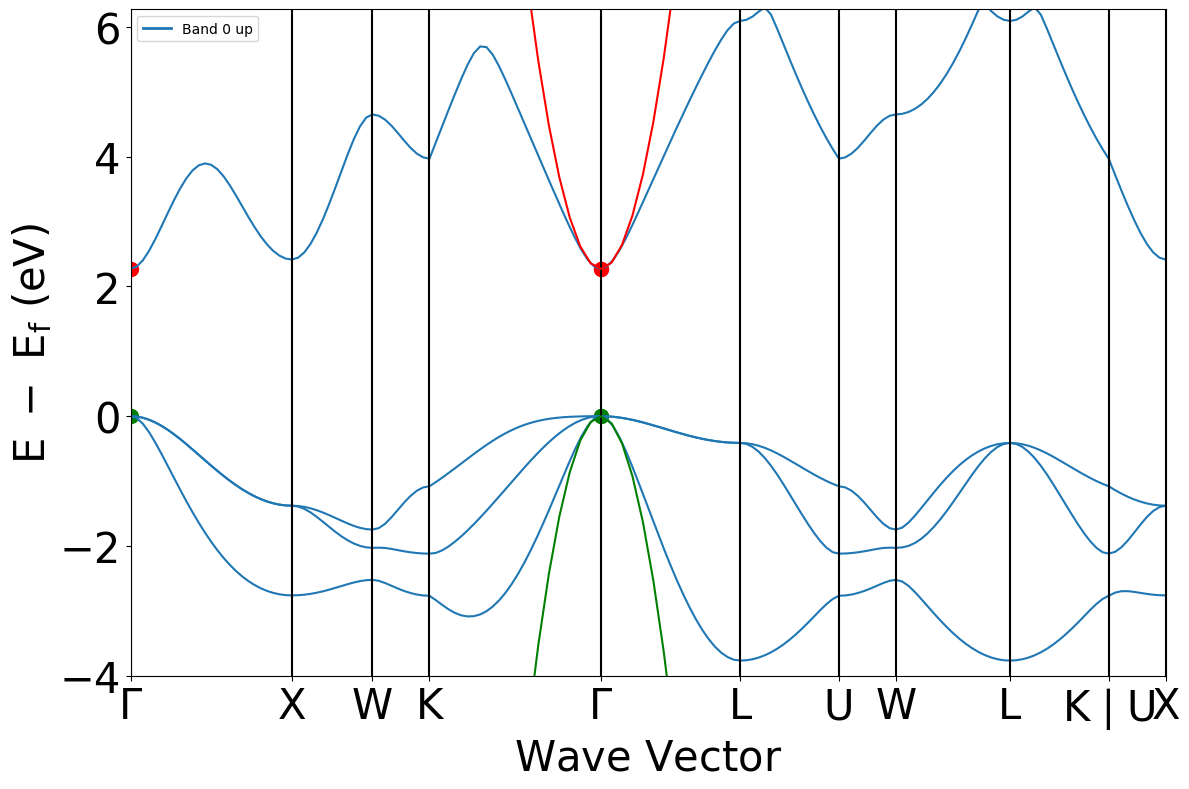

In [12]:
val_X = [distances[3][-3], distances[4][0], distances[4][3]]
cond_X = [distances[3][-3], distances[4][0], distances[4][3]]

val_Y = [energy[3][5][-3], energy[4][5][0], energy[4][5][3]]
cond_Y = [energy[3][8][-3], energy[4][8][0], energy[4][8][3]]

val_coeff = np.polyfit(val_X,val_Y, 2)
cond_coeff = np.polyfit(cond_X, cond_Y, 2)

X = np.linspace(0, distance[-1], 100)

cond_poly = cond_coeff[0] * X * X + cond_coeff[1] * X + cond_coeff[2]
val_poly = val_coeff[0] * X * X + val_coeff[1] * X + val_coeff[2]
bsplot.get_plot(vbm_cbm_marker=True)
plt.plot(X, cond_poly, color='red')
plt.plot(X, val_poly, color='green')

In [14]:
h_barre = 6.62607015e-34 / (2 * math.pi)
to_kg = 1e20/1.60218e-19
cond_mass = (h_barre ** 2/ (2 * cond_coeff[0])) * to_kg
val_mass = (h_barre ** 2/ (2 * val_coeff[0])) * to_kg
electron_mass = 9.1094e-31

print("Pour la bande de conduction:")
print(f"La masse effective à la base de la première bande de conduction est: {cond_mass} kg = {cond_mass/electron_mass} u.a.")
print("\n")
print("Pour la bande de valence:")
print(f"La masse effective au sommet de la dernière bande de valence est: {val_mass} kg = {val_mass/electron_mass} u.a.")

Pour la bande de conduction:
La masse effective à la base de la première bande de conduction est: 2.558451436364402e-31 kg = 0.28085839203069385 u.a.


Pour la bande de valence:
La masse effective au sommet de la dernière bande de valence est: -2.3059166986618976e-31 kg = -0.2531359583135989 u.a.
